<h1 style="font-size:35px;
        color:black;
        ">Lab 6 Grover’s search with an unknown number of solutions</h1>

Prerequisite
- [Ch.3.8 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)
- [Ch.3.9 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html)

Other relevant materials
- [Section 3.3 Measuring T1 in Ch.6.1](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#3.3-Measuring-$T_1$-using-Inversion-Recovery-)
- [Hellinger fidelity](https://qiskit.org/documentation/stubs/qiskit.quantum_info.hellinger_fidelity.html#qiskit.quantum_info.hellinger_fidelity)
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [186]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.utils.mitigation import *
from qiskit.circuit.library import QFT



import numpy as np
import matplotlib.pyplot as plt

<h2 style="font-size:24px;">Part 1: Quantum Counting</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Construct a circuit for quantum counting implementing the IPE (Iterative Phase Estimation) algorithm to find the number of solutions to a search problem.</p>
</div>


In [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html), we learned how to find search problem solutions through Grover's algorithm and the number of solutions utilizing the quantum counting circuit in [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html).  The number of solutions together with the number of total items in the search space determines the number of Grover iterations, and the number of oracle calls that are required. In part 1 of this lab, we build the quantum counting circuit implementing IPE the algorithm rather than the way the circuit was created in [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html) using Quantum Phase Estimation (QPE).

<h3 style="font-size: 20px">1. Find the number of solutions of the given oracle for a search problem through quantum counting. 

<h4 style="font-size: 17px">Step A. Construct a gate for Grover iteration. </h4>

Consider the search space with the total number of item, $N = 8$. Run the following cell to construct an oracle of a search problem.

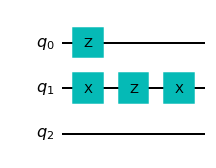

In [273]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')
myqc.x(1)
myqc.z(range(2))
myqc.x(1)

Oracle = myqc.to_gate()

myqc.draw('mpl')

&#128211; Complete the circuit, `qc`, to create Grover iteration gate/operator, `Grover`, by adding the diffuser, explained as the step 3 in the first section `1.Introduction` of [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html).

In [274]:
qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### your code goes here

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s

qc.append(diffuser(m), range(m))

qc.draw('mpl')













####

Grover = qc.to_gate()

<h4 style="font-size: 17px">&#128211;Step B. Build a quantum circuit, <code>circ</code>, for quantum counting employing the IPE algorithm to find the eigenvalue of the Grover iterator, <code>Grover</code> that we made in Step A. </h4>

Read [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html) before you start. Suppose the number of iteration of the IPE here is three, which corresponds to three counting qubits in QPE (Quantum Phase Estimate) circuit. (In other words, set the number of classical register to three.) 

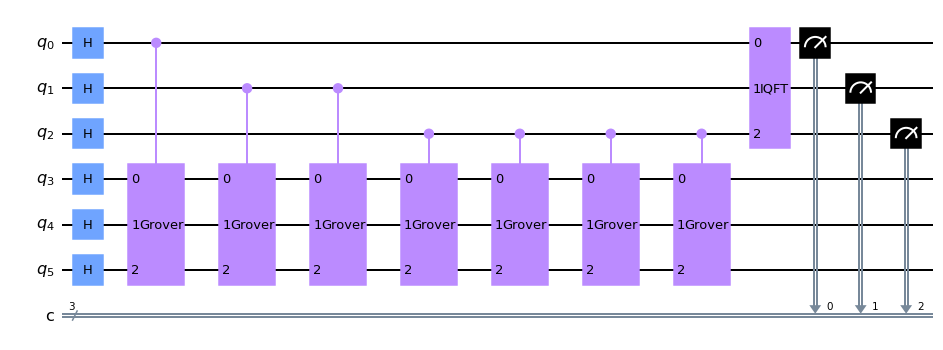

In [275]:
###### your code goes here

# set labels
Grover.label = "Grover"

#define the parameters here
t = m
n = m

circ = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    circ.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        circ.append(Grover.control(), [qubit] + [*range(t, n+t)])
    iterations *= 2
    

# import QFT
qft = QFT(t)
qft_dagger = qft.inverse()

# Do inverse QFT on counting qubits
circ.append(qft_dagger, range(t))

# Measure counting qubits
circ.measure(range(t), range(t))






###################    
circ.draw()

<h4 style="font-size: 17px">&#128211;Step C. Execute the circuit that you built in Step B and find the number of solutions, $M$, from the estimated phase. </h4>

In [276]:
sim = Aer.get_backend('aer_simulator')
shots = 20000

Results with bit strings {'110': 9904, '010': 10096}

Results with phases {'0.75': 9904, '0.25': 10096}


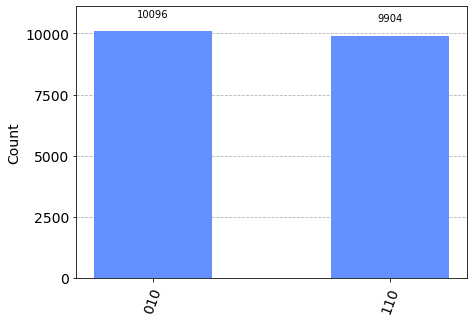

In [277]:
####### Your code goes here


# Execute and see results
hist = execute(circ, sim, shots=shots).result().get_counts()
print('Results with bit strings',hist)

def key_convert(count):
    phi_est = np.array([round(int(key, 2)/2**t, t) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

count_new = key_convert(hist)
print('\nResults with phases',count_new)

plot_histogram(hist)




In [278]:
measured_str = max(hist,key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

theta = (measured_int/(2**t))*np.pi*2
print("Theta = %.5f" % theta)

M = N * (np.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

Register Output = 2
Theta = 1.57080
No. of Solutions = 4.0


<h2 style="font-size:24px;">Part 2: Implementing Grover's algorithm with an augmented Oracle</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Construct a new augmented oracle to double the search space when the number of solutions, $M$, is more than or equal to the number of total items, $N$, $M \geq N/2$.</p>
</div>

When the number of solutions, $M$, is more than or equal to a half of the total items, $N$ ( $M \geq N/2$ ), 
the angle $\theta (= \arcsin(2\sqrt{M(N-M)}/N) )$, the amount of rotation toward to the solutions through each Grover iteration, gets smaller as $M$ varies from $N/2$ to $N$.  Therefore, the number of oracle calls required by the search algorithm rather increases with $M$ even though it should be easier to find a solution to the problem when the majority of the items is solution.  In Part 2 of this lab, we build a new augmented oracle that double the search space to resolve the issue. 

<h3 style="font-size: 20px"> 1. Understand the problem.</h3>

<h4 style="font-size: 17px">&#128211;Step A. Verify that the angle $\theta$ gets smaller as $M$ varies from $N/2$ to $N$. </h4>

Plot the relationship between $M$ and $\theta$ when $N = 2^{10}$.

Text(0.5, 1.0, 'relationship between M and $\\theta$')

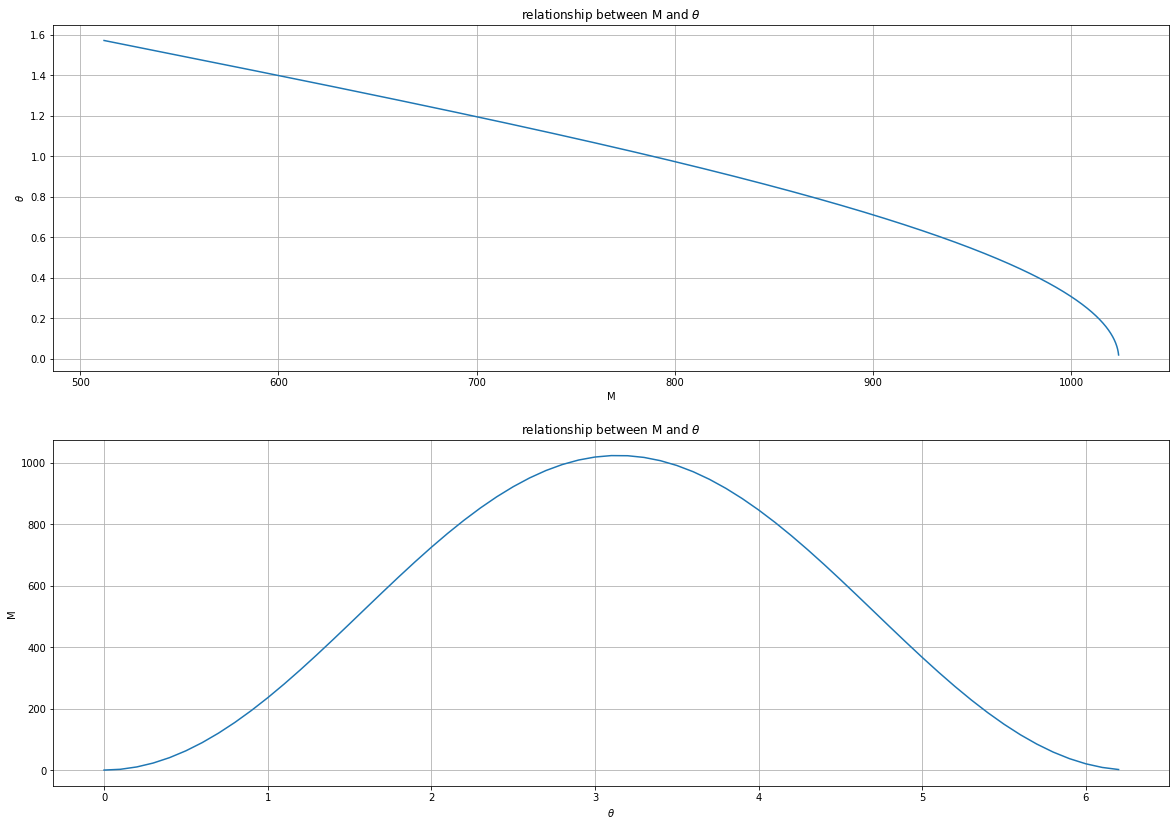

In [279]:
## Your code goes here

def m_as_function_of_theta(theta, N):
    return N*(np.sin(theta/2)**2)

def theta_as_function_of_m(M, N):
    return np.arcsin(2*np.sqrt(M*(N-M))/N)

theta_values = np.arange(0,2*np.pi,0.1)
N_prime = 2**10
m_values = np.arange(N_prime/2,N_prime,0.1)

fig, ax = plt.subplots(2, figsize = (20,14))

ax[0].plot(m_values, theta_as_function_of_m(m_values, N_prime))
ax[0].grid()
ax[0].set_ylabel("$\\theta$")
ax[0].set_xlabel("M")
ax[0].set_title("relationship between M and $\\theta$")

ax[1].plot(theta_values, m_as_function_of_theta(theta_values, N_prime))
ax[1].grid()
ax[1].set_xlabel("$\\theta$")
ax[1].set_ylabel("M")
ax[1].set_title("relationship between M and $\\theta$")















<h4 style="font-size: 17px">&#128211;Step B. Obtain the angle $\theta$ and the number of the Grover iterations, $R$, needed to find the solutions of the oracle in Part 1 and interpret the result.</h4>

In [QCQI] p253, $R$, is estimated through $R = CI(\frac{\arccos \sqrt{M/N}}{\theta})$ where $\theta$ is determined from $\sin\theta = \frac{2\sqrt{M(N-M)}}{N}$ and $CI(x)$ denotes the integer closest to the real number $x$, where by convention we round halves down, $CI(3.5)=3$, for example.

In [280]:
## Your code goes here

def closest_integer(x):
    answer = np.floor(x) if x <= np.floor(x) + 0.5 else np.ceil(x)
    return int(answer)

def r_parameter(M,N,theta):
    R = closest_integer(np.round(np.arccos(np.sqrt(M/N))/theta,4))
    
    return R

theta_prime = np.arcsin(2*np.sqrt(M*(N-M))/N)


print("The value of R for Part 1 is: " + str(r_parameter(M,N,theta_prime)))








The value of R for Part 1 is: 0


<h3 style="font-size: 20px"> 2. Find the solutions to the search problem from Part 1. </h3>

The solutions can be still found through Grover's algorithm when $M \geq N/2$ by doubling the search space with a single additional qubit $|q\rangle$ in the search index and building a new augmented oracle with the total number of items, $2N$, and $M$ number of solutions.

<h4 style="font-size: 17px">&#128211;Step A. Build a new augmented oracle gate/operator, <code>Oracle_new</code>, in the doubled search space.</h4>

With this new oracle in the doubled search space, the problem now is defined to find $M$ solutions out of 16 ( = 2x$N$ ) total items.  Therefore, less than half the items in the new search space are now solutions. 

As explained in [QCQI] Ch.6.1.4 (p255), the new augmented oracle marks an item only if it is a solution to the search problem and the extra bit is set to zero.  The augmented oracle may be constructed using one application of the original oracle, `Oracle` in Part 1 and elementary quantum gates, using the extra qubit $|q\rangle$.

16 4


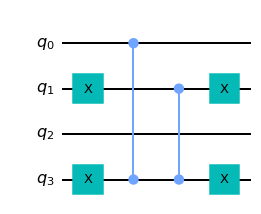

In [281]:
## your code goes here


## Create an Oracle

N = 2*8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

print(N,m)

myqc_new = QuantumCircuit(m, name='Oracle_new')
myqc_new.x(3)
myqc_new.x(1)
myqc_new.cz(3,range(2))
myqc_new.x(1)
myqc_new.x(3)

Oracle_new = myqc_new.to_gate()

myqc_new.draw('mpl')

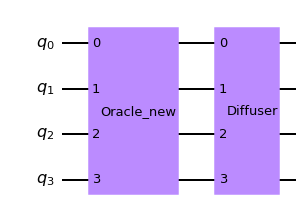

In [282]:
qc_new = QuantumCircuit(m)
qc_new.append(Oracle_new, range(m))
qc_new.append(diffuser(m), range(m))
Grover_new = qc_new.to_gate()
qc_new.draw()

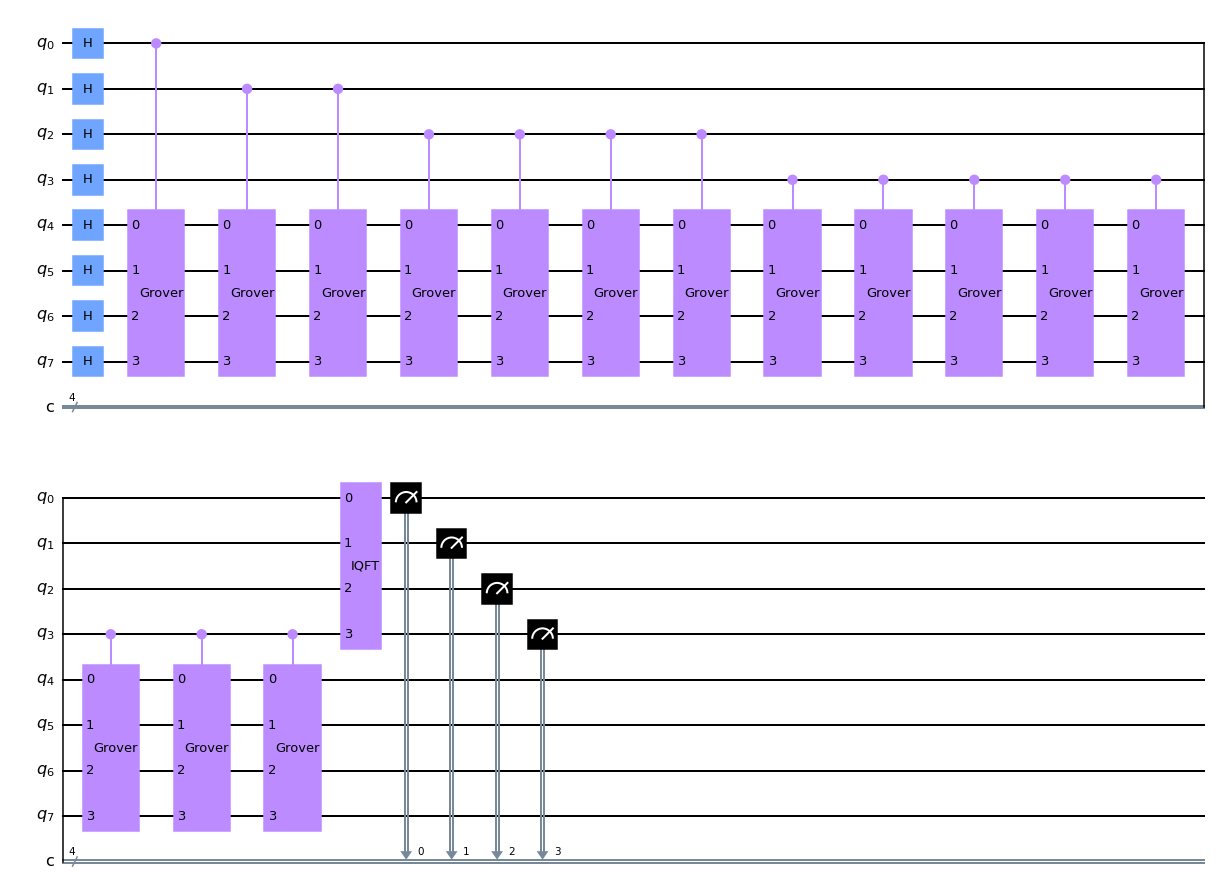

In [283]:
# set labels
Grover_new.label = "Grover"

#define the parameters here
t = m
n = m


circ_new = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    circ_new.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        circ_new.append(Grover_new.control(), [qubit] + [*range(t, n+t)])
    iterations *= 2
    

# import QFT
qft = QFT(t)
qft_dagger = qft.inverse()

# Do inverse QFT on counting qubits
circ_new.append(qft_dagger, range(t))

# Measure counting qubits
circ_new.measure(range(t), range(t))






###################    
circ_new.draw()

Results with bit strings {'0000': 73, '1110': 121, '0010': 97, '1101': 173, '1010': 1840, '1011': 6910, '0111': 363, '0011': 181, '1111': 83, '0001': 95, '1100': 476, '0101': 6812, '1001': 354, '0110': 1709, '1000': 239, '0100': 474}

Results with phases {'0.0': 73, '0.875': 121, '0.125': 97, '0.8125': 173, '0.625': 1840, '0.6875': 6910, '0.4375': 363, '0.1875': 181, '0.9375': 83, '0.0625': 95, '0.75': 476, '0.3125': 6812, '0.5625': 354, '0.375': 1709, '0.5': 239, '0.25': 474}


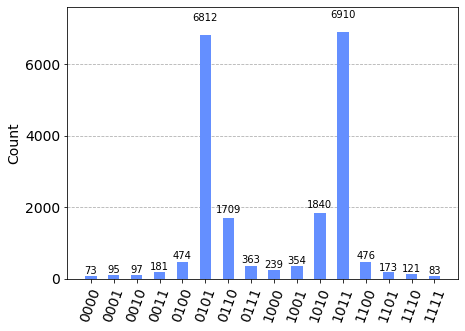

In [285]:
# Execute and see results
hist = execute(circ_new, sim, shots=shots).result().get_counts()
print('Results with bit strings',hist)

def key_convert(count):
    phi_est = np.array([round(int(key, 2)/2**t, t) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

count_new = key_convert(hist)
print('\nResults with phases',count_new)

plot_histogram(hist)


<h4 style="font-size: 17px">&#128211;Step B. Evaluate the number of Grover iterations, $R$, needed to find $M$ solutions among the total 16 items.</h4>

In [288]:
## Your code goes here

measured_str = max(hist,key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

theta = (measured_int/(2**t))*np.pi*2
print("Theta = %.5f" % theta)

M = N -  N * (np.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (M))


theta_prime = np.arcsin(2*np.sqrt(M*(N-M))/N)


print("The value of R for Part 2 is: " + str(r_parameter(M,N,theta_prime)))




Register Output = 11
Theta = 4.31969
No. of Solutions = 4.9
The value of R for Part 2 is: 1


<h4 style="font-size: 17px">&#128211;Step C. Create a quantum circuit <code>qc_final</code> to find solutions to the search problem applying Grover iteration <code>R</code> times.</h4>

A `diffuser` gate, that consist Grover iteration with `Oracle_new`, should be built accordingly for the new search space. Check the section 3.3.1 `Qiskit Implementation` in [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html) to learn how to build a general diffuser.

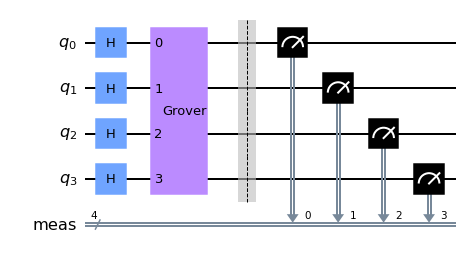

In [217]:
## Your code goes here



qc_final = QuantumCircuit(m)


qc_final.h(range(m))

qc_final.append(Grover_new, range(m))





qc_final.measure_all()







##########################

qc_final.draw()

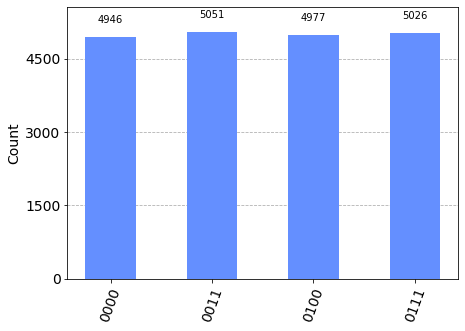

In [218]:
# Execute and see results
hist = execute(qc_final, sim, shots=shots).result().get_counts()

plot_histogram(hist)



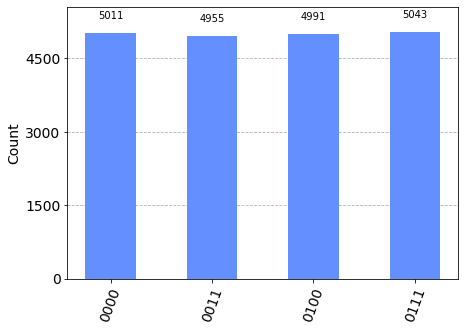

In [219]:
qc_final_trans = transpile(qc_final, sim)
count = sim.run(qc_final_trans, shots=shots).result().get_counts()
plot_histogram(count)

<h4 style="font-size: 17px">&#128211;Step D. Check if the solutions are correct using the original oracle, <code>Oracle</code>, in Part 1.</h4>

In [220]:
## your code goes here

m = 3

qc = QuantumCircuit(m)


qc.h(range(m))

qc.append(Grover, range(m))





qc.measure_all()







##########################

qc.draw()

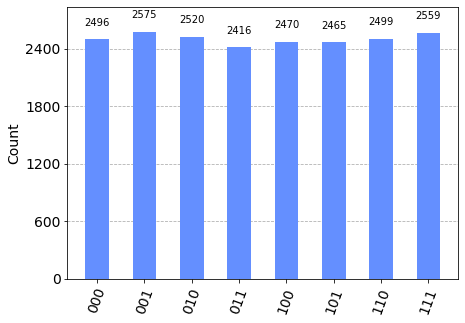

In [222]:
qc_trans = transpile(qc, sim)
count = sim.run(qc_trans, shots=shots).result().get_counts()
plot_histogram(count)

# As we expect, we can't solutions using grover when $M \geq N $ . The same can be seen in the histogram above, all solutions are equally probable.

<h2 style="font-size:24px;">Part 3: Grover circuit on Noisy Quantum System</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Execute the Grover circuit, that we built in Part 2 on a real quantum systems.</p>
</div>

In Part 3, we run the circuit `qc_final` that we set up in Part 2 to find the solutions to the search problem on a real quantum system. Since the present day quantum computers are noisy, the answer from it will not be the same as the simulation result that we obtained in Part 2. We examine how noise affects the outcome and discuss the possible sources of the error.

<h4 style="font-size: 17px">&#128211;Step A. Load your account, set your provider and choose a backend. </h4>

In [228]:
## your code goes here

IBMQ.providers()

provider = IBMQ.get_provider('ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [247]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
                                        not x.configuration().simulator and x.status().operational==True))
print(backend)
backend.jobs


ibmq_quito


<bound method IBMQBackend.jobs of <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>>

<h4 style="font-size: 17px">&#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc_final</code>. Choose one with the minimum circuit depth.</h4>

As we learned in Lab3, we can increase the fidelity in the results from noisy quantum systems by minimizing the depth of the circuit that we run.  

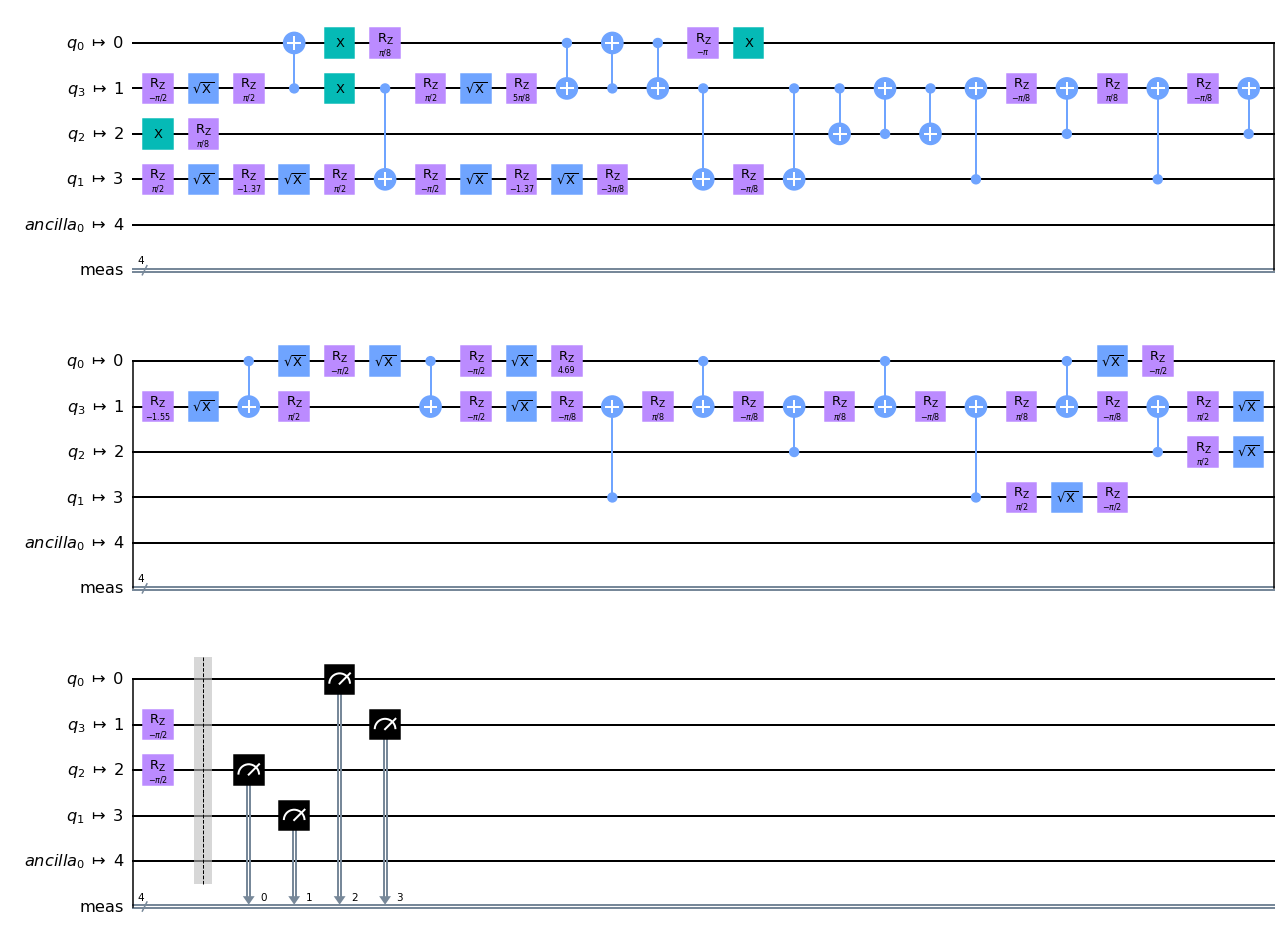

In [251]:
## your code goes here

qc_final_trans_lowest_depth = []
depth_least = 100
iterations = 1000
for i in range(iterations):
    qc_trans = transpile(qc_final, backend, optimization_level=3)
    #print(qc_trans.depth())
    depth = qc_trans.depth()
    if  depth < depth_least:
        depth_least = depth
        qc_final_trans_lowest_depth.clear()
        qc_final_trans_lowest_depth.append(qc_trans)

qc_final_trans = qc_final_trans_lowest_depth[0]

qc_final_trans.draw()
    
    
    











In [253]:
print("The least transpiled depth is: "+str(qc_final_trans.depth()))

The least transpiled depth is: 52


<h4 style="font-size: 17px">&#128211;Step C. Execute the circuit on the backend. </h4>

In [254]:
shots = 8192
## Your code goes here
job = backend.run(qc_final_trans, shots=8192)
print(job.job_id())
job_monitor(job)
    
output = job.result().get_counts()






63c7c77aa2561e3c98b750be
Job Status: job has successfully run


<h4 style="font-size: 17px">&#128211;Step D. Plot the histogram of the result from the selected backend together with the simulation result. Compute the fidelity of the result from the real quantum system to compare with the simulation one.</h4>

Check [Hellinger fidelity](https://qiskit.org/documentation/stubs/qiskit.quantum_info.hellinger_fidelity.html#qiskit.quantum_info.hellinger_fidelity).Think about why some of the solutions are affected by noise more than others.

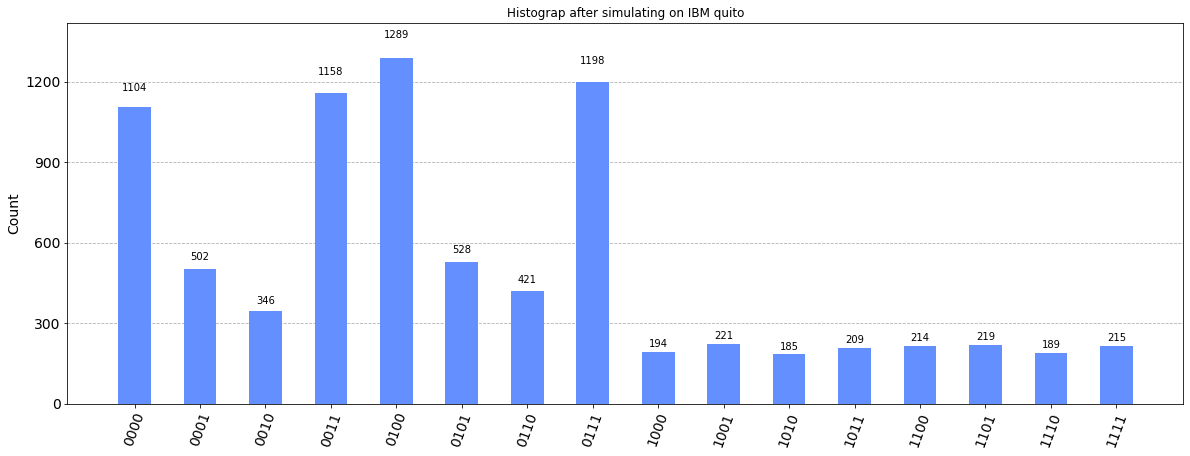

In [271]:
## Your code goes here


plot_histogram(output, figsize=(20,7), title = "Histograp after simulating on IBM quito")




In [266]:
qc_final_trans = transpile(qc_final, sim)
count = sim.run(qc_final_trans, shots=shots).result().get_counts()

In [267]:
from qiskit.quantum_info.analysis import hellinger_fidelity
fidelity = hellinger_fidelity(output, count)

print("The fidelity is: " + str(fidelity))

The fidelity is: 0.5788781420423553
